# **Analysis of Twitch Social Network**

## **Introduction**

This project focuses on analyzing the social network of Twitch using the dataset provided by SNAP (Stanford Network Analysis Project). Twitch is a live-streaming platform, primarily for gaming, hosting a vast community of streamers and viewers. The Twitch social network is represented as an undirected graph, where nodes are users, and edges represent mutual friendships. This project aims to study the interaction dynamics, community structures, and user behaviors within the network.

---

## **Project Objectives**

### 1. **User Behavior Analysis**
I will examine the interactions between users on the platform by analyzing metrics such as:
- Node degree (number of connections).
- Centrality (relative importance of a node in the network).
- Distribution of connections and identification of influential users.

### 2. **Community Detection**
I will apply community detection algorithms to identify groups of users that are strongly connected. This will help to understand how communities form based on shared characteristics.

### 3. **Explicit Content Analysis**
I will train a model able to predict if a streamer uses explicit language based on their connections and attributes. This will be achieved using supervised machine learning techniques, leveraging node attributes and graph connections.

---

## **Tools Used**
- **Python**: The primary programming language.
- **NetworkX**: For graph manipulation and analysis.
- **Scikit-learn**: For implementing machine learning models.
- **Matplotlib/Seaborn**: For data and result visualization.
- **Gephi**: For interactive network visualization.


---



## **1. Data Loading and Preprocessing**


In [30]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import seaborn as sns
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### 1. Load the dataset, including:
   - Edge list: representing user connections on Twitch.
   - Node features: describing user attributes (e.g., language, streaming behavior).

In [31]:
# Load the edge list
edgelist = pd.read_csv('large_twitch_edges.csv', )
# Display the first few rows to understand the structure
edgelist.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [32]:
# Load CSV file with node features
node_features = pd.read_csv("large_twitch_features.csv", index_col=5)
# Display the first few rows to understand the structure
node_features.head()

,views,mature,life_time,created_at,updated_at,dead_account,language,affiliate
numeric_id,,,,,,,,
0,7879,1,969,2016-02-16,2018-10-12,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,0,EN,0


In [33]:
node_features.describe()

,views,mature,life_time,dead_account,affiliate
count,1.681140e+05,168114.000000,168114.000000,168114.000000,168114.000000
mean,1.881618e+05,0.470116,1541.812116,0.030688,0.485064
std,3.326119e+06,0.499108,715.704133,0.172470,0.499778
min,0.000000e+00,0.000000,11.000000,0.000000,0.000000
25%,1.415000e+03,0.000000,997.000000,0.000000,0.000000
50%,4.117000e+03,0.000000,1540.000000,0.000000,0.000000
75%,1.420800e+04,1.000000,2027.000000,0.000000,1.000000
max,3.843966e+08,1.000000,4161.000000,1.000000,1.000000


At first sight, I note that:
- **Edge List**: Represents the connections between Twitch users, where each row is a link between two users (`numeric_id_1` and `numeric_id_2`).
- **Node Features**: Contains attributes for each user (node) such as:
  - `views`: Total number of views a streamer has.
  - `mature`: Indicates if the streamer produces mature content (1 for yes, 0 for no).
  - `life_time`: Lifetime of the user's account (in days).
  - `created_at` and `updated_at`: Account creation and last update dates.
  - `dead_account`: Indicates if the account is inactive.
  - `language`: The main language used by the user.
  - `affiliate`: Indicates if the user is a Twitch affiliate (1 for yes, 0 for no).

### 2. Clean and preprocess the data:
   - Handle missing values and duplicates.

In [34]:
# Check for null values and duplicates in the edge list
print("### Edge List ###")
print(f"Total rows in edge list: {edgelist.shape[0]}")

# Check for null values
null_values_edges = edgelist.isnull().sum()
print("Null values in edge list:")
print(null_values_edges)

# Check for duplicates
duplicates_edges = edgelist.duplicated().sum()
print(f"Duplicate rows in edge list: {duplicates_edges}")

print("\n")

# Check for null values and duplicates in the node attributes
print("### Node Attributes ###")
print(f"Total rows in node attributes: {node_features.shape[0]}")

# Check for null values
null_values_nodes = node_features.isnull().sum()
print("Null values in node attributes:")
print(null_values_nodes)

### Edge List ###
Total rows in edge list: 6797557
Null values in edge list:
numeric_id_1    0
numeric_id_2    0
dtype: int64
Duplicate rows in edge list: 0


### Node Attributes ###
Total rows in node attributes: 168114
Null values in node attributes:
views           0
mature          0
life_time       0
created_at      0
updated_at      0
dead_account    0
language        0
affiliate       0
dtype: int64


- **Edge List**:
  - No null values found in `numeric_id_1` or `numeric_id_2`.
  - No duplicate rows detected.

- **Node Attributes**:
  - No null values in any columns (`views`, `mature`, `life_time`, etc.).

Both datasets are clean and ready for the next step: building the graph using the edge list and enriching it with node attributes.

### 3. Build the graph:
   - Use NetworkX to create the graph from the edge list.
   - Add node features to the graph.

In [35]:
OG = nx.from_pandas_edgelist(edgelist, source='numeric_id_1', target='numeric_id_2', create_using=nx.Graph())
print(OG)
print('Is the graph directed ?',OG.is_directed())

Graph with 168114 nodes and 6797557 edges
Is the graph directed ? False


I built an **undirected graph** where:
* Nodes are Twitch streamers.
* Edges are mutual friendships between Twitch streamers.


In [36]:
# Add node features to the graph
nx.set_node_attributes(OG, node_features.to_dict(orient='index'))

# Check correctness of this operation
example_node = list(OG.nodes)[0]
print(f"Attributes for node {example_node}: {OG.nodes[example_node]}")

Attributes for node 98343: {'views': 282, 'mature': 0, 'life_time': 2086, 'created_at': '2012-12-27', 'updated_at': '2018-09-13', 'dead_account': 0, 'language': 'EN', 'affiliate': 0}


Another important step is to check for **self loops** and removing them:

In [37]:
OG.remove_edges_from(nx.selfloop_edges(OG))
print(OG)

Graph with 168114 nodes and 6797557 edges


As we can see from the output, no edges have been removed.


For the purposes of this project and to facilitate analysis, I will take into account only a part of the network of Twitch streamers.
At first, I filter the nodes with `language` attribute and count them :


In [38]:
language_counts = defaultdict(int)

# Iteration through nodes
for node, attr in OG.nodes(data=True):
    language = attr.get('language', 'Unknown')
    language_counts[language] += 1

# Print 
for language, count in language_counts.items():
    print(f"Language: {language}, Count: {count}")

Language: EN, Count: 124411
Language: OTHER, Count: 1429
Language: ZH, Count: 2828
Language: ES, Count: 5699
Language: SV, Count: 854
Language: DE, Count: 9428
Language: RU, Count: 4821
Language: CS, Count: 576
Language: DA, Count: 503
Language: KO, Count: 1215
Language: IT, Count: 1230
Language: NL, Count: 701
Language: PT, Count: 2536
Language: NO, Count: 330
Language: FI, Count: 652
Language: FR, Count: 6799
Language: TR, Count: 772
Language: JA, Count: 1327
Language: HU, Count: 427
Language: TH, Count: 632
Language: PL, Count: 944


**French** network has a medium size, so I will use it as starting point, creating an independent subgraph (`G`) from the original one (`OG`)

In [39]:
# Filter nodes with attribute 'language' = 'FR'
nodes_with_fr = [n for n, attr in OG.nodes(data=True) if attr.get('language') == 'FR']

# Create independent subgraph
G = OG.subgraph(nodes_with_fr).copy()

print(G)
print(f'Is the graph directed?', G.is_directed())

Graph with 6799 nodes and 123644 edges
Is the graph directed? False


In [40]:
example_node = list(G.nodes)[0]
print(f"Attributes for node {example_node}: {G.nodes[example_node]}")

Attributes for node 32768: {'views': 1183, 'mature': 1, 'life_time': 280, 'created_at': '2018-01-04', 'updated_at': '2018-10-11', 'dead_account': 0, 'language': 'FR', 'affiliate': 1}


### 4. Save the cleaned data for later use.

In this section, I will save the Graph in a format compatible with Gephi, for visualisation.

In [41]:
nx.write_graphml(G, "twitch_networkFR.graphml")

### 5. Network Visualisation


The visualisation below is elaborated with Gephi. 

I used ForceAtlas2 and coloured nodes with green (non-affiliated streamers) and red (affiliated streamers). 


![vis1](visualisations/vis1.png)

This ForceAtlas2 visualization of the network reveals some key features of the graph:

1. **Clustering**:
    
   There is a **central cluster** that contains nodes that are highly connected, likely representing influential or well-integrated streamers within the network. The **peripheral nodes** are less connected and likely represent either new streamers or those with minimal interaction in the network. We can see that the majority of peripheral nodes are not affiliated streamers, meaning that nodes that are less connected / important aren't in collaboration with the platform.

2. **Community Detection**:

   An important point to explore is if there are distinct communities within the network, and how affiliation and other attributes correlate with these groups. At first sight, we can see a big central cluster, but this could be divided in more communities, maybe based on type of content or seniority.



---

## **2. USER BEHAVIOR ANALYSIS**


This section focuses on a deeper understanding of network features, in particular on how users are connected and interact.

At first, I will compute density:

In [42]:
density = nx.density(G)
print(f"Density of graph: {density}")

Density of graph: 0.005350284063458616


The Twitch French network has a density of **0.00535**, indicating that only the 0.5% of all possible connections are available. 

The network is **sparse**. This is typical for large social networks, where users selectively connect to a small subset of others with similar interests rather than forming a densely connected graph.

Future analysis will explore the role of highly connected nodes (hubs) in linking otherwise sparse parts of the network.

---
### 1. Degree analysis

Proceeding with analysis of degree, I compute it for each node in the graph...

In [43]:
G_degree=G.degree()
G_degreelist=list(dict(G.degree()).values())
len(G_degreelist)

6799

... and I put it in a list from which I can compute some statistics:

In [44]:
print(f'Average degree is', np.mean(G_degreelist))
print(f'Minimum degree is', np.min(G_degreelist))
print(f'Maximum degree is', np.max(G_degreelist))
print(f'Median degree is', np.median(G_degreelist))

Average degree is 36.371231063391676
Minimum degree is 0
Maximum degree is 2081
Median degree is 19.0


The degree analysis reveals key insights about the Twitch French network:
- The **average degree** is **36.37**, indicating that each user is, on average, connected to 36 other users.
- The **median degree** is **19**, highlighting that most users have fewer connections than the average, due to the possible influence of highly connected hubs.
- The **maximum degree** is **2081**, representing a key hub in the network, while some nodes are completely isolated (**minimum degree** = 0).

This suggests a highly **asymmetric degree distribution**, likely following a power-law, with a few influential nodes connecting the majority of less connected users. Let's check ECDF to prove it.

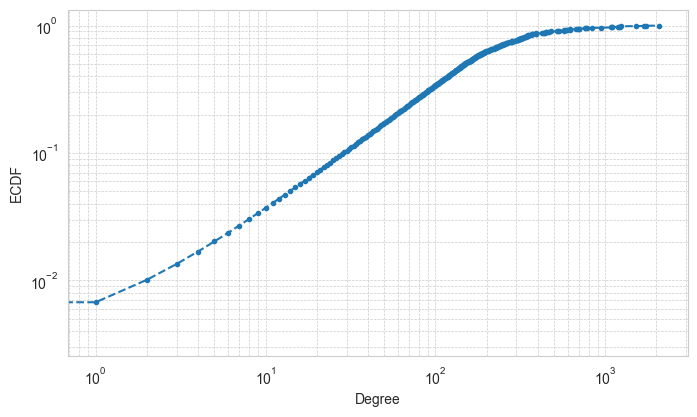

In [45]:
# ECDF function
def ECDF(x):
    y = np.arange(1, len(x) + 1) / len(x)
    return y

# Set axis
x = np.unique(G_degreelist)
y = ECDF(x)

# Plot
fig_cdf_function = plt.figure(figsize=(8,4.5))
axes = fig_cdf_function.gca()
axes.loglog(x,y, linestyle = '--', marker= 'o', ms=3)
axes.set_xlabel('Degree')
axes.set_ylabel('ECDF')
plt.grid(which="both", linestyle="--", linewidth=0.5)

ECDF of the network shows a **long tail**, typical of **scale-free networks**, where few hubs have a high degree, while the majority has a low degree. This structure is typical of social network, where few users have a lot of connections. 

To better understand the structure, let's compare ECCDF with two important models: **random networks** (Erdős-Rényi) and **small-world models** (Watts-Strogatz).

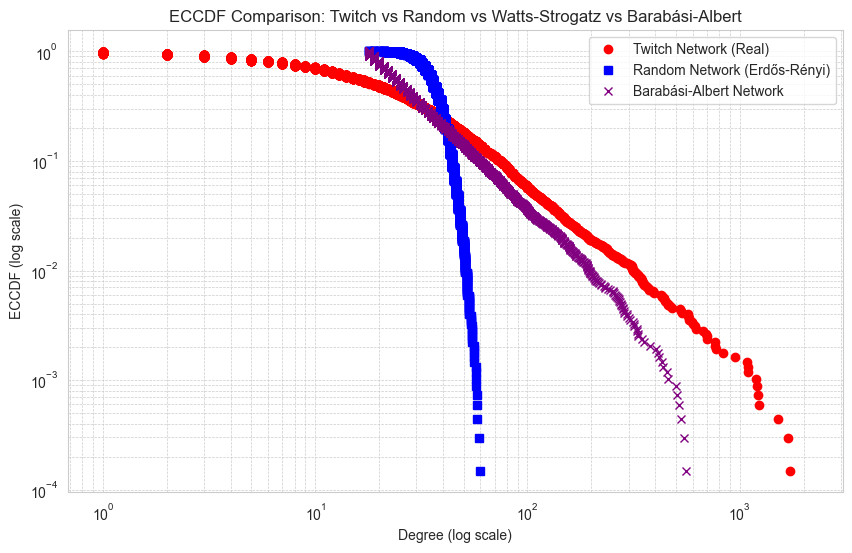

In [46]:
# ECCDF Function
def ECCDF(degree_sequence):
    sorted_degrees = np.sort(degree_sequence)
    ECCDF = 1 - ECDF(sorted_degrees)
    return sorted_degrees, ECCDF  # ECCDF = 1 - CDF

# Degree sequence for the real graph
real_degrees = [d for _, d in G.degree()]

# Generate random graph (Erdős-Rényi)
random_graph = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
random_degrees = [d for _, d in random_graph.degree()]

# Generate BA graph
ba_graph = nx.barabasi_albert_graph(n=G.number_of_nodes(), m=int(np.mean(real_degrees) // 2))
ba_degrees = [d for _, d in ba_graph.degree()]

# Compute ECCDFs
real_x, real_eccdf = ECCDF(real_degrees)
random_x, random_eccdf = ECCDF(random_degrees)
ba_x, ba_eccdf = ECCDF(ba_degrees)

# Plot ECCDFs
plt.figure(figsize=(10, 6))
plt.loglog(real_x, real_eccdf, label="Twitch Network (Real)", marker="o", linestyle="none", color="red")
plt.loglog(random_x, random_eccdf, label="Random Network (Erdős-Rényi)", marker="s", linestyle="none", color="blue")
plt.loglog(ba_x, ba_eccdf, label="Barabási-Albert Network", marker="x", linestyle="none", color="purple")

plt.xlabel("Degree (log scale)")
plt.ylabel("ECCDF (log scale)")
plt.title("ECCDF Comparison: Twitch vs Random vs Watts-Strogatz vs Barabási-Albert")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

- The **Erdős-Rényi model** fails to replicate the heterogeneity of the Twitch network, as it generates networks with a uniform degree distribution. There are no hubs.
- The **Barabási-Albert model** provides the closest approximation to the real network, highlighting the preferential attachment mechanism behind the emergence of hubs.

This comparison confirms that the Twitch network follows a scale-free structure, with the Barabási-Albert model being the most suitable representation of its degree distribution.


---
### **2. Connectivity**


In this section, I analyze the role of hubs in maintaining the connectivity of the network. Hubs are defined as nodes with a degree in the top 5% of the network (95th percentile).

In [47]:
hub_threshold = np.percentile(G_degreelist, 95)
hubs = {k for k, v in G.degree() if v >= hub_threshold}
print(f"Hub threshold: {hub_threshold}")
print(f"Number of hubs: {len(hubs)}")

Hub threshold: 108.09999999999945
Number of hubs: 340


Nodes with a degree **higher than 108** are classified as hubs.

I found a total of **340 hubs**, which are the top 5% of the most connected nodes. 

Now, let's compute _connected components_:

In [48]:
connected_components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(f"Number of connected components: {len(connected_components)}")
print(f"Size of largest connected component: {connected_components[0]}") 
print(f'Size of each component: {connected_components}')

Number of connected components: 78
Size of largest connected component: 6720
Size of each component: [6720, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The network contains **78** connected components. Checking the dimensione of each of them, I stated that there is one **giant component** with 6720 nodes and all the other components are of size 1 or 2.

Let's move on with analysis of hubs:

In [49]:
# Subgraph of hubs
hub_subgraph = G.subgraph(hubs).copy()
nx.write_gexf(hub_subgraph, "hubs.gexf")
#  Number of connected components bw hubs
hubs_ccs = len(list(nx.connected_components(hub_subgraph)))
print(f"Number of connected components among hubs: {hubs_ccs}")

# Size of largest hub component
hub_components_sizes = [len(c) for c in sorted(nx.connected_components(hub_subgraph), key=len, reverse=True)]
print(f"Size of largest hub component: {hub_components_sizes[0]}")

Number of connected components among hubs: 1
Size of largest hub component: 340


Anylizing the subgraph of hubs (_figure below_) reveals that they form a **single connected component**. This means that top streamers in Twitch are strongly interconnected and form a dense network.

![hubs](hubs.png)

Let's check what happens if I remove hubs from the network:

In [50]:
# Remove hubs
G_no_hubs = G.copy()
G_no_hubs.remove_nodes_from(hubs)

# Number of connected components after hub removal
no_hubs_components = [len(c) for c in sorted(nx.connected_components(G_no_hubs), key=len, reverse=True)]
print(f"Number of connected components without hubs: {len(no_hubs_components)}")
print(f"Size of largest component without hubs: {no_hubs_components[0]}") 
print(f'Size of each component: {no_hubs_components}')

Number of connected components without hubs: 374
Size of largest component without hubs: 6075
Size of each component: [6075, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [85]:
print(f'Density of hubs subgrafh is', nx.density(hub_subgraph))
print(f'Density of network without hubs is', nx.density(G_no_hubs))

Density of hubs subgrafh is 0.14874197466597258
Density of network without hubs is 0.0021258037991838457


Removing the 340 hubs increases the number of connected components from 78 to 374, which might appear as a significant increase. However, this **growth is largely meaningless**, as the newly disconnected components consist predominantly of isolated nodes or very small clusters of size 1 or 2.

The size of the largest connected component decreases only slightly, from 6,720 to 6,075 nodes, retaining the vast majority of the network.

A big difference in density is stated:
- Hubs are connected with a density of 15%.
- Graph without hubs decreases in density from 0.5% to 0.2%. 

This demonstrates that while hubs play a key role in connecting smaller peripheral components, the network’s core structure remains **robust** and **largely unaffected** by their removal.

---
### **3. Triangles and Clustering**

In this section, we aim to analyze the local and global clustering properties of the Twitch network.
We address two specific research questions.



Global Clustering Coefficient: 0.2204
Average number of triangles (Hubs): 2478.05
Average number of triangles (Non-Hubs): 104.33


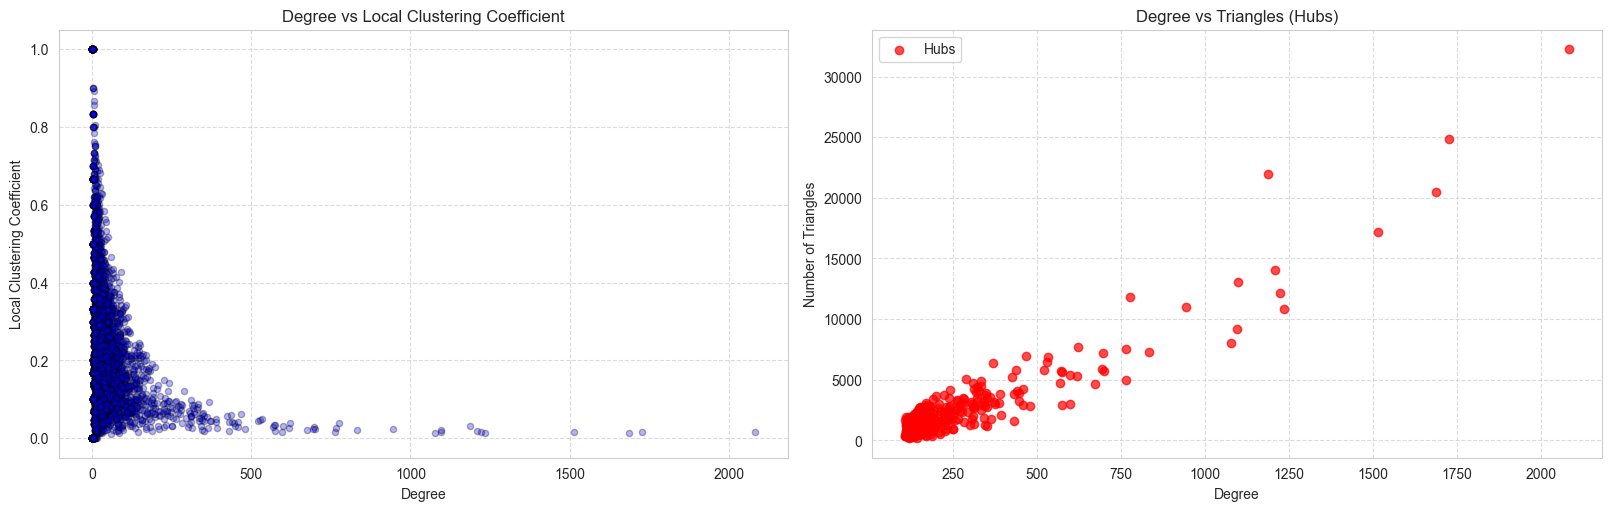

In [52]:
# Compute global clustering coefficient
global_clustering = nx.average_clustering(G)
print(f"Global Clustering Coefficient: {global_clustering:.4f}")

# Compute local clustering coefficient for each node
local_clustering = nx.clustering(G)
degree_clustering = {node: (G.degree[node], local_clustering[node]) for node in G.nodes}
degrees, clustering_coeffs = zip(*degree_clustering.values())
# Assign clustering coefficient as a node attribute
nx.set_node_attributes(G, local_clustering, name="clustering_coefficient")

# Compute number of triangles for each node
triangles = nx.triangles(G)

# Compute triangles for hubs
hub_triangles = {hub: triangles[hub] for hub in hubs}

# Compute average number of triangles for hubs and non-hubs
non_hubs = set(G.nodes) - set(hubs)
non_hub_triangles = {node: triangles[node] for node in non_hubs}

avg_hub_triangles = np.mean(list(hub_triangles.values()))
avg_non_hub_triangles = np.mean(list(non_hub_triangles.values()))

print(f"Average number of triangles (Hubs): {avg_hub_triangles:.2f}")
print(f"Average number of triangles (Non-Hubs): {avg_non_hub_triangles:.2f}")

# Compute degree and triangles of hubs
hub_degrees = [G.degree[hub] for hub in hub_triangles.keys()]
hub_triangle_counts = list(hub_triangles.values())

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# 1. Degree vs Clustering Coefficient
axes[0].scatter(degrees, clustering_coeffs, alpha=0.3, color="blue", edgecolor="black", s=20)
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Local Clustering Coefficient")
axes[0].set_title("Degree vs Local Clustering Coefficient")
axes[0].grid(linestyle="--", alpha=0.7)

# 2. Degree vs Triangles (Hubs)
axes[1].scatter(hub_degrees, hub_triangle_counts, color="red", alpha=0.7, label="Hubs")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Number of Triangles")
axes[1].set_title("Degree vs Triangles (Hubs)")
axes[1].grid(linestyle="--", alpha=0.7)
axes[1].legend()

plt.show()

#### - What is the global clustering coefficient? Does it indicate that the network is highly clustered?
The **global clustering coefficient** of the Twitch network is **0.2205**, which is relatively low. This result indicates that 22% of potential triangles is actually closed. This results confirms the hypothesis that hubs act as bridges for isolated communities or nodes but don't necessarily rely on a central structure position. However, local neighborhoods may still show dense structures, likely driven by specific groups or communities within the network.

#### - Do the most influential streamers (hubs) participate in a significant number of triangles?

The high difference on average number of triangles between hub and non-hub nodes suggests that they play a crucial role in creation of dense local structures (triangles) in the network. 

The scatter plot illustrates that _low-degree nodes_ have a wide range of clustering coefficients, with some reaching the maximum value of 1. This indicates that low-degree nodes are often part of **small, tightly connected groups**. These likely represent **localized communities** who interact frequently.

Nodes with a _high degree tend_ to have **lower clustering coefficients**, reflecting the difficulty of forming triangles as the number of neighbors increases. This is typical in **scale-free networks**, where hubs connect many nodes but their neighbors are less likely to be interconnected. Hubs connect communities but are not strongly embedded in any specific group, serving as **bridges between different communities**.


### **4. Centrality**

This section will try to identify **most central streamers** according to different centrality measures.

In [53]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

After computing centrality according to different measures, I extract the top 10 nodes for each measure:

In [54]:
# Extract top 10 nodes
def get_top_n_nodes(centrality_dict, n=10):
    sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:n]

# for each centrality measure
top_degree = get_top_n_nodes(degree_centrality)
top_closeness = get_top_n_nodes(closeness_centrality)
top_betweenness = get_top_n_nodes(betweenness_centrality)
top_pagerank = get_top_n_nodes(pagerank)


print("Top 10 Nodes by Degree Centrality:")
for node, value in top_degree:
    print(f"Node: {node}, Value: {value:.5f}")

print("\nTop 10 Nodes by Closeness Centrality:")
for node, value in top_closeness:
    print(f"Node: {node}, Value: {value:.5f}")

print("\nTop 10 Nodes by Betweenness Centrality:")
for node, value in top_betweenness:
    print(f"Node: {node}, Value: {value:.5f}")

print("\nTop 10 Nodes by PageRank:")
for node, value in top_pagerank:
    print(f"Node: {node}, Value: {value:.5f}")

Top 10 Nodes by Degree Centrality:
Node: 43374, Value: 0.30612
Node: 73257, Value: 0.25405
Node: 29715, Value: 0.24801
Node: 121165, Value: 0.22271
Node: 86212, Value: 0.18152
Node: 119716, Value: 0.17976
Node: 103342, Value: 0.17770
Node: 21793, Value: 0.17476
Node: 94380, Value: 0.16137
Node: 92107, Value: 0.16108

Top 10 Nodes by Closeness Centrality:
Node: 43374, Value: 0.56775
Node: 73257, Value: 0.54145
Node: 29715, Value: 0.53991
Node: 121165, Value: 0.52497
Node: 21793, Value: 0.52086
Node: 103342, Value: 0.51830
Node: 86212, Value: 0.51171
Node: 119716, Value: 0.50842
Node: 94380, Value: 0.50814
Node: 136920, Value: 0.50440

Top 10 Nodes by Betweenness Centrality:
Node: 43374, Value: 0.09400
Node: 73257, Value: 0.06945
Node: 29715, Value: 0.05670
Node: 121165, Value: 0.05363
Node: 119716, Value: 0.03619
Node: 103342, Value: 0.03550
Node: 92107, Value: 0.03486
Node: 86212, Value: 0.03446
Node: 21793, Value: 0.02926
Node: 86522, Value: 0.02386

Top 10 Nodes by PageRank:
Node: 43

Node **43374** ranks highest across all centrality mesaures, proving its role as the most influential and well-connected node in the network. It may represent the **most famous French Twitch streamer**. 
Notice that also Pagerank value is high meaning that this streamer has also important connections. 

Anyway, the top 10 ranking is almost the same in every measure, meaning that these nodes are important for different purposes.

Now, I compute a **correlation matrix** to get some insights about the structure of the network:

<Axes: >

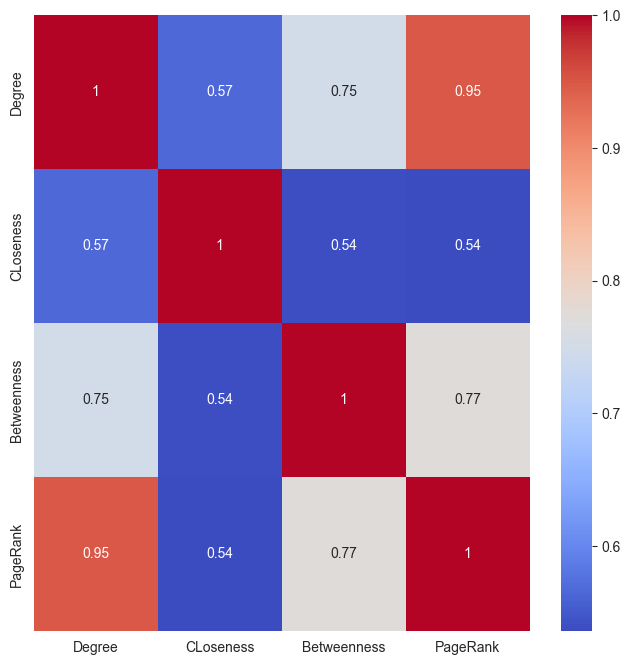

In [68]:
df_centrality = pd.DataFrame({
    'Degree': pd.Series(degree_centrality),
    'CLoseness': pd.Series(closeness_centrality),
    'Betweenness': pd.Series(betweenness_centrality),
    'PageRank': pd.Series(pagerank)
})

# Compute correlation matrix
corr = df_centrality.corr(method='kendall')

# Visualization
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax = ax)

Key observations:
1. **High correlation between degree and [PageRank, betweenness]** (0.95, 0.75). In the case of PageRank, this means that most followed streamers have also strong association with other influential users.
 High betweenness correlation suggests that "influencers" are important in connecting different communities.
2. **Moderate correlation between degree and closeness** (0.57).
This relation is weak. It means that highly-connected nodes aren't necessary close to all nodes in terms of path lenght. Streamers may be very popular in dense communities, but not so close to others even though they're connected to them.
3. **Weak correlation of closeness with betweenness and PageRank** (0.54 both). 
This low correlation is mainly referred to the definition of closeness, which relies on path length rather than number of connections. This could mean that streamers who are structurally central may not be so influent in the network.


Let's add degree as a node attribute so I can understand common features that important streamers have in common:


In [56]:
# Calculate the degree for each node in the graph
node_degrees = dict(G.degree())

# Add the degree as a node attribute
nx.set_node_attributes(G, node_degrees, name="degree")

In [57]:
top_nodes = [43374, 73257, 29715, 121165, 86212, 119716, 103342, 21793, 94380, 92107]

node_data = []

# Retrieve attributes for each node and store in a list
for node in top_nodes:
    if node in G.nodes:
        attributes = G.nodes[node]  # Get node attributes
        attributes['node_id'] = node  # Add node ID as an attribute
        node_data.append(attributes)  # Append to the list

node_df = pd.DataFrame(node_data)

node_df

,views,mature,life_time,created_at,updated_at,dead_account,language,affiliate,clustering_coefficient,degree,node_id
0,44374644,1,2027,2013-03-25,2018-10-12,0,FR,0,0.014902,2081,43374
1,17166188,0,2419,2012-02-27,2018-10-12,0,FR,0,0.016649,1727,73257
2,42801507,0,610,2017-02-09,2018-10-12,0,FR,0,0.014397,1686,29715
3,44534929,0,2613,2011-08-17,2018-10-12,0,FR,0,0.014987,1514,121165
4,4890741,0,1783,2013-11-24,2018-10-12,0,FR,0,0.014229,1234,86212
5,22400233,1,2480,2011-12-28,2018-10-12,0,FR,0,0.016251,1222,119716
6,62713570,0,1311,2015-03-11,2018-10-12,0,FR,0,0.019261,1208,103342
7,9194058,1,2853,2010-12-20,2018-10-12,0,FR,0,0.031172,1188,21793
8,5875963,0,1261,2015-04-30,2018-10-12,0,FR,0,0.021720,1097,94380
9,5760863,0,3530,2009-02-11,2018-10-12,0,FR,0,0.015387,1095,92107


The table reports attributes of top 10 most important nodes in centrality. Note that: 
* **degree** and **number of views** are hugely above the mean values. 
* **created_at** field shows that most of these nodes have been active for a long time (as early as 2009-2012). This suggests that these top nodes are long-standing accounts, possibly indicating veteran streamers or influential figures in the network.
* Interestingly, none of these nodes appear to have the **affiliate status** set to 1. This could mean that they operate independently or belong to a different structure in the Twitch ecosystem.
---

## **2. Community detection**

Now, I apply community detection procedure to identify groups of nodes with similar characteristics, and I will proceed with the analysis of these groups.

#### **1. Louvain Algorithm**

Let's start with the application of Louvain algorithm, which aims to find communities basing on internal density of them.

In [58]:
# Compute communities using Louvain algorithm
communities = nx.community.louvain_communities(G, seed=42)

# Print number of communities
num_communities = len(communities)
print(f"Number of communities detected: {num_communities}")

# Associate communities to nodes attributes
node_to_community = {}
for community_id, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_to_community[node] = community_id

nx.set_node_attributes(G, node_to_community, "community")

Number of communities detected: 83


The algorithm found 83 communities but, checking the size of them, there are **77 communities formed by 1 or 2 nodes**. This result is strictly related to previous analysis of connected components, where I found exactly 77 components of 1 or 2 nodes. For this reason, I don't consider these couples of nodes as communities. 

Next, I computed **community size** and **average value of features** to get some insights:

In [59]:
community_data = defaultdict(list)

# Dictionary with node attributes
for node, attributes in G.nodes(data=True):
    community = node_to_community.get(node, -1)  # Ottieni la comunità del nodo
    if community != -1:  # Escludi nodi senza comunità valida
        community_data[community].append(attributes)

# Group by community
aggregated_data = []
for community, nodes in community_data.items():
    aggregated_features = {
        'community': community,
        'node_count': len(nodes),
    }
    numeric_features = pd.DataFrame(nodes)

    # Don't considere dates and language
    numeric_columns = numeric_features.select_dtypes(include=["number"])
    aggregated_features.update(numeric_columns.mean().to_dict())  # Average
    aggregated_data.append(aggregated_features)

# Convert and print the dataframe, considering only communities larger than 1 or 2 nodes
community_stats = pd.DataFrame(aggregated_data)
community_stats = community_stats.drop(columns=['node_id'])
community_stats[community_stats['node_count']>2]

,community,node_count,views,mature,life_time,dead_account,affiliate,clustering_coefficient,degree
0,54.0,564,23849.035461,0.501773,1412.698582,0.014184,0.576241,0.246487,35.226950
1,50.0,1367,177681.799561,0.302853,1226.850037,0.016825,0.502560,0.210644,33.845647
2,3.0,1440,335651.115278,0.331250,1382.093056,0.015972,0.506944,0.287925,35.055556
4,16.0,1509,137310.284294,0.295560,1743.430749,0.028496,0.387674,0.245670,41.880716
5,36.0,1695,145566.881416,0.497345,1428.571091,0.013569,0.614159,0.155125,37.530383
6,48.0,145,18547.317241,0.482759,1250.213793,0.000000,0.737931,0.162097,26.600000


The analysis of communities reveals some interesting patterns:

1. **Community Size:** Communities vary widely in size, with some, like Community 36 (1695 nodes), being significantly larger and likely more central, while smaller ones, like Community 48 (145 nodes), appear more peripheral.

2. **Engagement (Views):** Community 3 stands out with a high average of views (335,651), indicating popular streamers, while others, like Community 48 (18,547), represent less active or less followed groups.

3. **Professionalization (Affiliation):** Community 48 has a high affiliate ratio (0.73), suggesting a professionalized group, whereas Community 16 (0.38) may consist of more casual streamers.

4. **Connectivity (Degree):** Community 16 shows the highest average degree (41.88), reflecting high interconnectivity, while Community 48 is less dense (26.60).

5. **Clustering:** Communities like 3 (0.28) have higher clustering coefficients, indicating tight-knit groups, while others, like 48 (0.16), are less cohesive.

These findings suggest a mix of central, influential communities and smaller, peripheral ones.

---

#### **2. Node2Vec Approach**

**Node2Vec** is a feature learning algorithm that captures structural and relational properties of nodes in a graph by generating _low-dimensional vector representations_. In this section, I leverage the Node2Vec algorithm to generate node embeddings and then use **K-Means clustering** to group nodes into clusters.

At first, I generate embeddings of nodes:

In [64]:
nodes_list = list(G.nodes())
node2vec = Node2Vec(G, dimensions=20, walk_length=10, num_walks=100, p=1, q=3, workers=1)
model = node2vec.fit(window=7, min_count=0, batch_words=4)

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


After obtainining the vector representation, I apply K-Means with the same number of clusters as communities found with Louvain (=6).


In [65]:
data_points = [model.wv[str(e)] for e in nodes_list]
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
kmeans.fit(data_points)
labels = kmeans.fit_predict(data_points)

# Silhouette score
silhouette_avg = silhouette_score(data_points, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Assign clusters to nodes
node_clusters = pd.DataFrame({'node': nodes_list, 'cluster': labels})
node_clusters.head()
for node, cluster in zip(node_clusters['node'], node_clusters['cluster']):
    G.nodes[int(node)]['cluster'] = cluster

Silhouette Score: 0.0659


A Silhouette Score of **0.07** indicates that the clusters generated with KMeans are **poorly defined**, with little separation between groups and significant overlap between nodes. This suggests that the data does not lend itself well to KMeans clustering, at least using Node2Vec vectors and pre-fixed number of clusters (without using Elbow method, for example).

I assign clusters back to node and generate a dataframe with characteristics for each cluster:

In [66]:
# Extract features
node_data = []
for node, data in G.nodes(data=True):
    attributes = data.copy() 
    attributes['node_id'] = node
    attributes['cluster'] = data.get('cluster', -1) 
    node_data.append(attributes)
    
node_df = pd.DataFrame(node_data)

# Compute mean of numerical features
numeric_columns = node_df.select_dtypes(include='number')
cluster_means = numeric_columns.groupby(node_df['cluster']).mean()

# Drop node_id
cluster_means = cluster_means.drop(columns=['node_id'])

cluster_means

,views,mature,life_time,dead_account,affiliate,clustering_coefficient,degree,community,cluster
cluster,,,,,,,,,
0,22830.284069,0.499040,1437.067179,0.017274,0.570058,0.256106,36.644914,53.078695,0.0
1,437516.649552,0.308883,1263.740831,0.010595,0.548492,0.289445,36.862266,28.592502,1.0
2,140410.149539,0.501772,1386.929128,0.015592,0.627215,0.128098,33.718639,34.107725,2.0
3,171653.539738,0.300437,1460.213974,0.026201,0.455022,0.285770,31.760699,12.805240,3.0
4,76464.368280,0.275090,1782.846774,0.028674,0.354839,0.249666,42.191756,16.808244,4.0
5,121729.994924,0.406091,1374.831037,0.017404,0.518492,0.162130,37.662799,39.327049,5.0


As stated before, there aren't significant differences between the features of each community.

Let's compare the two methods using Normalised Mutual Information:

In [67]:
# Create a dictionary to compare Louvain and K-Means algorithms
com4nodes = {n : {'lou': 0, 'clus':0 } for n in nodes_list}
for i, nodes in enumerate(communities):
    for node in nodes:
        com4nodes[node]['lou'] = i
for i, e in enumerate(nodes_list):
    com4nodes[e]['clus'] = kmeans.labels_[i]


v_louvain = np.zeros(len(nodes_list))
v_clus = np.zeros(len(nodes_list))
for i, e in enumerate(nodes_list):
    v_louvain[i] = com4nodes[e]['lou']
    v_clus[i] = com4nodes[e]['clus']
normalized_mutual_info_score(v_louvain, v_clus)

0.3902563725868938

An NMI of **0.39** shows that there is only **moderate similarity** between the partitions obtained with the two methods. This means that KMeans clusters finds some difficulties to capture the intrinsic community structure of the network well.

Summing up,

<u>Advantages of Louvain:</u>
- **Modularity Approach:** Louvain maximizes modularity, which measures the density of connections within clusters compared to between clusters. It works well for networks with clear community structures, such as social networks.
- **Natural Community Distribution:** Louvain does not require the number of communities to be specified beforehand, unlike KMeans, which requires a fixed `k` that can be difficult to determine.

<u>Limitations of Node2Vec + KMeans:</u>
- **Parameter Sensitivity:** Node2Vec relies on the careful tuning of parameters such as `p`, `q`, and the number of clusters `k`. Poor parameter choices can lead to suboptimal results.
- **Dependence on Embeddings:** The embeddings generated by Node2Vec may not fully capture the complex structural relationships within the network, especially for networks with isolated nodes or highly heterogeneous communities.


By adopting a visual approach, I generated a network visualization where nodes were colored based on their assigned cluster or community. As expected, the visualization using communities (detected by Louvain) creates distinct areas of color with varying densities, reflecting well-defined community structures. In contrast, the visualization based on K-Means clustering lacks clarity, with clusters appearing less distinct and less representative of the network's inherent structure.



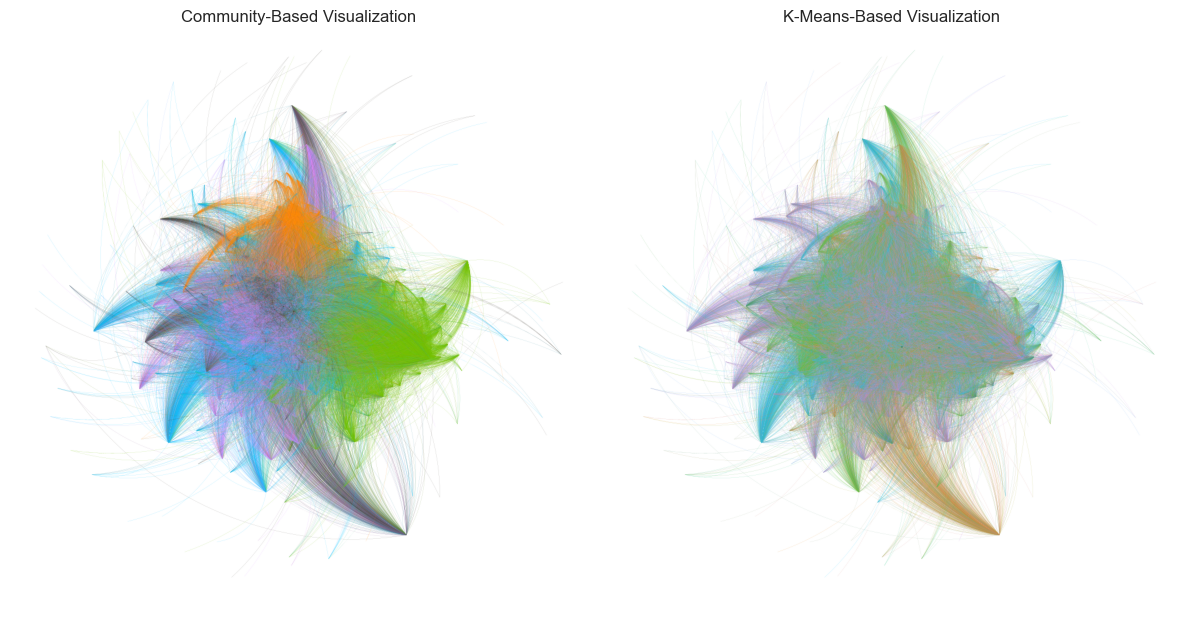

In [65]:

img1 = mpimg.imread('communities.png') 
img2 = mpimg.imread('clusters.png') 


fig, axes = plt.subplots(1, 2, figsize=(12, 7))  # 1 riga, 2 colonne
axes[0].imshow(img1)
axes[0].axis('off') 
axes[0].set_title('Community-Based Visualization')

axes[1].imshow(img2)
axes[1].axis('off')  
axes[1].set_title('K-Means-Based Visualization')

plt.tight_layout()
plt.show()

In [ ]:
nx.write_graphml(G, "wcomm.graphml")

## **3. Node classification**

In this section, I predict whether a Twitch streamer uses explicit language (`1`) or not (`0`) using **machine learning on graphs**.

I employ a **Random Forest classifier** to evaluate three feature sets:
1. **Content-based features**: Individual node attributes like views and affiliate status.
2. **Structural features**: Graph-based metrics like degree, clustering coefficient, and Node2Vec embeddings.
3. **Combined features**: Integration of content and structural features.

This approach explores how node attributes and network structure contribute to predicting explicit content usage.

In [71]:
# 1. Add all measures needed for this purpose as node attributes

#Centrality measures
nx.set_node_attributes(G, degree_centrality, name='degree_centrality')
nx.set_node_attributes(G, closeness_centrality, name='closeness_centrality')
nx.set_node_attributes(G, betweenness_centrality, name='betweenness_centrality')
nx.set_node_attributes(G, pagerank, name='pagerank')

# Embeddings (Node2Vec)
embeddings_dict = {node: embedding for node, embedding in zip(nodes_list, data_points)}

for node in G.nodes():
    G.nodes[node]['embedding'] = embeddings_dict.get(node, None)

# Check results
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")
    break

Node 32768: {'views': 1183, 'mature': 1, 'life_time': 280, 'created_at': '2018-01-04', 'updated_at': '2018-10-11', 'dead_account': 0, 'language': 'FR', 'affiliate': 1, 'clustering_coefficient': 0.38181818181818183, 'degree': 11, 'community': 54, 'cluster': 0, 'degree_centrality': 0.0016181229773462782, 'closeness_centrality': 0.40015172717139735, 'betweenness_centrality': 2.3865049741884622e-05, 'pagerank': 5.8576543920640776e-05, 'embedding': array([ 0.49406996, -0.5587477 ,  0.37994274,  0.09588597,  0.51354176,
        0.5782265 ,  0.8013843 ,  0.27960297, -0.66518164,  0.23014201,
       -0.39423063, -0.70988744,  0.32053658, -0.02617968, -0.37364554,
        0.9899204 ,  0.08706697,  0.46920615,  0.02263254, -1.0578108 ],
      dtype=float32)}


In [72]:
# 2. Create a dataframe with all node attributes
node_data = []
for node, attributes in G.nodes(data=True):
    data = attributes.copy()
    data['node_id'] = node
    node_data.append(data)


node_df = pd.DataFrame(node_data)

node_df

,views,mature,life_time,created_at,updated_at,dead_account,language,affiliate,clustering_coefficient,degree,community,cluster,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,embedding,node_id
0,1183,1,280,2018-01-04,2018-10-11,0,FR,1,0.381818,11,54,0,0.001618,0.400152,0.000024,0.000059,"[0.49406996, -0.5587477, 0.37994274, 0.0958859...",32768
1,27482,1,1156,2015-08-13,2018-10-12,0,FR,1,0.177187,43,54,0,0.006325,0.383248,0.000041,0.000155,"[0.20978217, -0.3674735, 0.17793746, 0.3289330...",98307
2,37032,1,1429,2014-11-13,2018-10-12,0,FR,1,0.202186,61,50,5,0.008973,0.429833,0.000236,0.000223,"[-0.29352605, 0.17845179, -0.39226416, 0.00936...",65539
3,775,1,577,2017-03-14,2018-10-12,0,FR,0,0.333333,9,3,3,0.001324,0.383580,0.000002,0.000051,"[-0.21089825, 0.7511478, 0.13792045, 0.2304308...",7
4,1772,1,717,2016-10-02,2018-09-19,0,FR,0,0.073529,17,3,2,0.002501,0.374115,0.000031,0.000085,"[0.16681147, 0.07167652, 0.3922814, 0.17099234...",163848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,1629,1,651,2016-12-30,2018-10-12,0,FR,0,0.286988,34,36,1,0.005001,0.416411,0.000052,0.000130,"[-0.02434874, -0.06572824, 0.11389786, 0.54010...",65507
6795,7058,1,1698,2014-02-17,2018-10-12,0,FR,0,0.208081,45,16,3,0.006620,0.424693,0.000082,0.000161,"[-0.44606435, 0.058991555, 0.5301689, 0.309606...",65509
6796,977531,0,1552,2014-07-13,2018-10-12,0,FR,0,0.033198,234,50,5,0.034422,0.410110,0.001813,0.000895,"[-0.5956931, -0.18549527, -0.6975549, 0.499248...",131045
6797,62211,0,1274,2015-04-12,2018-10-07,0,FR,0,0.155556,46,50,5,0.006767,0.404589,0.000188,0.000181,"[-0.32970932, 0.41685298, -0.037512127, 0.5785...",32746


In [74]:
# 3. Explode embeddings in separated columns
embeddings_df = pd.DataFrame(
    node_df['embedding'].tolist(), 
    index=node_df.index
)

# Rename columns
embeddings_df.columns = [f'node2vec_{i}' for i in range(embeddings_df.shape[1])]

# Add embeddings to original dataframe
node_df = pd.concat([node_df, embeddings_df], axis=1)

node_df

,views,mature,life_time,created_at,updated_at,dead_account,language,affiliate,clustering_coefficient,degree,...,node2vec_10,node2vec_11,node2vec_12,node2vec_13,node2vec_14,node2vec_15,node2vec_16,node2vec_17,node2vec_18,node2vec_19
0,1183,1,280,2018-01-04,2018-10-11,0,FR,1,0.381818,11,...,-0.394231,-0.709887,0.320537,-0.026180,-0.373646,0.989920,0.087067,0.469206,0.022633,-1.057811
1,27482,1,1156,2015-08-13,2018-10-12,0,FR,1,0.177187,43,...,0.495418,-0.316815,0.322242,-0.166154,0.650137,-0.261589,-0.541781,0.172555,0.110783,-1.214073
2,37032,1,1429,2014-11-13,2018-10-12,0,FR,1,0.202186,61,...,0.242422,-0.166799,-0.386837,-0.420845,0.141065,0.454054,-0.059711,-0.248053,-0.254234,-0.810525
3,775,1,577,2017-03-14,2018-10-12,0,FR,0,0.333333,9,...,0.270231,-0.296088,0.192784,-0.456935,-0.285991,0.397685,0.718953,0.008875,-0.713817,-0.820523
4,1772,1,717,2016-10-02,2018-09-19,0,FR,0,0.073529,17,...,0.158114,-0.329640,-0.752818,-0.346186,0.487108,0.076958,0.574323,-0.625883,-0.221933,-0.345999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,1629,1,651,2016-12-30,2018-10-12,0,FR,0,0.286988,34,...,0.538629,-0.615457,-0.295250,0.400904,0.766590,0.498018,0.471587,-0.060988,0.052355,-0.893060
6795,7058,1,1698,2014-02-17,2018-10-12,0,FR,0,0.208081,45,...,0.784836,-0.329406,0.354198,-0.007958,0.307434,0.406525,0.449139,-0.250648,-0.597700,0.004861
6796,977531,0,1552,2014-07-13,2018-10-12,0,FR,0,0.033198,234,...,0.152930,0.201223,-0.036807,0.510035,-0.245645,-0.063168,0.363490,-0.675197,-0.173350,-0.852489
6797,62211,0,1274,2015-04-12,2018-10-07,0,FR,0,0.155556,46,...,0.118956,-0.252602,-0.038157,0.197126,0.077671,0.438552,0.368799,-0.447396,0.444594,-0.325833


In [75]:
# 4. Create content-based features dataframe
content_features = node_df[['mature', 'views', 'affiliate', 'life_time', 'dead_account']]  # Sostituisci con i nomi reali delle colonne

content_features

,mature,views,affiliate,life_time,dead_account
0,1,1183,1,280,0
1,1,27482,1,1156,0
2,1,37032,1,1429,0
3,1,775,0,577,0
4,1,1772,0,717,0
...,...,...,...,...,...
6794,1,1629,0,651,0
6795,1,7058,0,1698,0
6796,0,977531,0,1552,0
6797,0,62211,0,1274,0


In [76]:
# 5. Create structural features dataframe
structural_features = node_df[
    ['mature', 'degree', 'clustering_coefficient', 'betweenness_centrality', 'pagerank', 'degree_centrality', 'closeness_centrality'] + 
    [col for col in node_df.columns if col.startswith('node2vec_')]
]

structural_features

,mature,degree,clustering_coefficient,betweenness_centrality,pagerank,degree_centrality,closeness_centrality,node2vec_0,node2vec_1,node2vec_2,...,node2vec_10,node2vec_11,node2vec_12,node2vec_13,node2vec_14,node2vec_15,node2vec_16,node2vec_17,node2vec_18,node2vec_19
0,1,11,0.381818,0.000024,0.000059,0.001618,0.400152,0.494070,-0.558748,0.379943,...,-0.394231,-0.709887,0.320537,-0.026180,-0.373646,0.989920,0.087067,0.469206,0.022633,-1.057811
1,1,43,0.177187,0.000041,0.000155,0.006325,0.383248,0.209782,-0.367474,0.177937,...,0.495418,-0.316815,0.322242,-0.166154,0.650137,-0.261589,-0.541781,0.172555,0.110783,-1.214073
2,1,61,0.202186,0.000236,0.000223,0.008973,0.429833,-0.293526,0.178452,-0.392264,...,0.242422,-0.166799,-0.386837,-0.420845,0.141065,0.454054,-0.059711,-0.248053,-0.254234,-0.810525
3,1,9,0.333333,0.000002,0.000051,0.001324,0.383580,-0.210898,0.751148,0.137920,...,0.270231,-0.296088,0.192784,-0.456935,-0.285991,0.397685,0.718953,0.008875,-0.713817,-0.820523
4,1,17,0.073529,0.000031,0.000085,0.002501,0.374115,0.166811,0.071677,0.392281,...,0.158114,-0.329640,-0.752818,-0.346186,0.487108,0.076958,0.574323,-0.625883,-0.221933,-0.345999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,1,34,0.286988,0.000052,0.000130,0.005001,0.416411,-0.024349,-0.065728,0.113898,...,0.538629,-0.615457,-0.295250,0.400904,0.766590,0.498018,0.471587,-0.060988,0.052355,-0.893060
6795,1,45,0.208081,0.000082,0.000161,0.006620,0.424693,-0.446064,0.058992,0.530169,...,0.784836,-0.329406,0.354198,-0.007958,0.307434,0.406525,0.449139,-0.250648,-0.597700,0.004861
6796,0,234,0.033198,0.001813,0.000895,0.034422,0.410110,-0.595693,-0.185495,-0.697555,...,0.152930,0.201223,-0.036807,0.510035,-0.245645,-0.063168,0.363490,-0.675197,-0.173350,-0.852489
6797,0,46,0.155556,0.000188,0.000181,0.006767,0.404589,-0.329709,0.416853,-0.037512,...,0.118956,-0.252602,-0.038157,0.197126,0.077671,0.438552,0.368799,-0.447396,0.444594,-0.325833


In [77]:
# 6. Combine the two dataframes
combined_features = pd.concat([content_features.drop(columns=['mature']), structural_features], axis=1)
combined_features['mature'] = content_features['mature']

combined_features

,views,affiliate,life_time,dead_account,mature,degree,clustering_coefficient,betweenness_centrality,pagerank,degree_centrality,...,node2vec_10,node2vec_11,node2vec_12,node2vec_13,node2vec_14,node2vec_15,node2vec_16,node2vec_17,node2vec_18,node2vec_19
0,1183,1,280,0,1,11,0.381818,0.000024,0.000059,0.001618,...,-0.394231,-0.709887,0.320537,-0.026180,-0.373646,0.989920,0.087067,0.469206,0.022633,-1.057811
1,27482,1,1156,0,1,43,0.177187,0.000041,0.000155,0.006325,...,0.495418,-0.316815,0.322242,-0.166154,0.650137,-0.261589,-0.541781,0.172555,0.110783,-1.214073
2,37032,1,1429,0,1,61,0.202186,0.000236,0.000223,0.008973,...,0.242422,-0.166799,-0.386837,-0.420845,0.141065,0.454054,-0.059711,-0.248053,-0.254234,-0.810525
3,775,0,577,0,1,9,0.333333,0.000002,0.000051,0.001324,...,0.270231,-0.296088,0.192784,-0.456935,-0.285991,0.397685,0.718953,0.008875,-0.713817,-0.820523
4,1772,0,717,0,1,17,0.073529,0.000031,0.000085,0.002501,...,0.158114,-0.329640,-0.752818,-0.346186,0.487108,0.076958,0.574323,-0.625883,-0.221933,-0.345999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,1629,0,651,0,1,34,0.286988,0.000052,0.000130,0.005001,...,0.538629,-0.615457,-0.295250,0.400904,0.766590,0.498018,0.471587,-0.060988,0.052355,-0.893060
6795,7058,0,1698,0,1,45,0.208081,0.000082,0.000161,0.006620,...,0.784836,-0.329406,0.354198,-0.007958,0.307434,0.406525,0.449139,-0.250648,-0.597700,0.004861
6796,977531,0,1552,0,0,234,0.033198,0.001813,0.000895,0.034422,...,0.152930,0.201223,-0.036807,0.510035,-0.245645,-0.063168,0.363490,-0.675197,-0.173350,-0.852489
6797,62211,0,1274,0,0,46,0.155556,0.000188,0.000181,0.006767,...,0.118956,-0.252602,-0.038157,0.197126,0.077671,0.438552,0.368799,-0.447396,0.444594,-0.325833


In [79]:
# 7. Prediction

# Function to train and evaluate the Random Forest model
def train_and_evaluate(features, mature, dataset_name):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, mature, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print evaluation results
    print(f"\nResults for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Train and evaluate on content-based features
train_and_evaluate(
    features=content_features.drop(columns=['mature']),
    mature=content_features['mature'],
    dataset_name="Content Features"
)

# Train and evaluate on structural-based features
train_and_evaluate(
    features=structural_features.drop(columns=['mature']),
    mature=structural_features['mature'],
    dataset_name="Structural Features"
)

# Train and evaluate on combined features
train_and_evaluate(
    features=combined_features.drop(columns=['mature']),
    mature=combined_features['mature'],
    dataset_name="Combined Features"
)


Results for Content Features:
Accuracy: 0.5853
Precision: 0.4689
Recall: 0.3540
F1 Score: 0.4034

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68      1232
           1       0.47      0.35      0.40       808

    accuracy                           0.59      2040
   macro avg       0.55      0.55      0.54      2040
weighted avg       0.57      0.59      0.57      2040


Results for Structural Features:
Accuracy: 0.6647
Precision: 0.6615
Recall: 0.3144
F1 Score: 0.4262

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76      1232
           1       0.66      0.31      0.43       808

    accuracy                           0.66      2040
   macro avg       0.66      0.60      0.59      2040
weighted avg       0.66      0.66      0.63      2040


Results for Combined Features:
Accuracy: 0.6618
Precision: 0.6335
Recall: 0.3465
F1 Score: 0.448

Some comments on these results:

- **Content Features**:
  - Accuracy: 58.53%, F1 Score: 40.34% – The lowest performance overall. Content features alone fail to provide sufficient predictive power due to the lack of relational context.

- **Structural Features**:
  - Accuracy: 66.47%, F1 Score: 42.62% – The best accuracy among all feature sets, showing the importance of relational and positional information in the graph.

- **Combined Features**:
  - Accuracy: 66.18%, F1 Score: 44.80% – Slight improvement in recall and F1 score compared to structural features alone, but the added value of content features is minimal.

**Key Takeaway**: Structural features are the most predictive, while combined features provide marginal improvements. Content features alone perform the worst due to the lack of network context.